In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [2]:
"""Load and prepare the dataset

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

# df = pd.read_feather(data_dir / "resource_results.feather")
df = pd.read_feather(data_dir / "fortio_results.feather")

df = df[df["experiment"] == exp_name]
df = df.drop("actual_qps", 1)
df = df.explode("latency")
df = df.reset_index(drop=True)
df = df.astype({
    "experiment": "category",
    "mesh": "category",
    "requested_qps": "category",
    "payload": "category",
    "protocol": "category",
    "latency": np.float64,
})

df = df.sort_values("mesh", ascending=True)

df.head()

,experiment,mesh,requested_qps,protocol,payload,latency
39588490,01_http_max_throughput,Baseline,MAX,http,0,1.260004
41873570,01_http_max_throughput,Baseline,MAX,http,0,1.494196
41873569,01_http_max_throughput,Baseline,MAX,http,0,1.552722
41873568,01_http_max_throughput,Baseline,MAX,http,0,1.545147
41873567,01_http_max_throughput,Baseline,MAX,http,0,1.533766


In [3]:
# The quantiles to plot
quantiles = [
    0.99,
    0.999,
    0.9999
]

data = df.groupby("mesh")["latency"].quantile(quantiles)
data = data.reset_index().rename(columns={"level_1": "percentile"})
data["percentile"] *= 100
data.head()

,mesh,percentile,latency
0,Baseline,99.00,7.420944
1,Baseline,99.90,12.984117
2,Baseline,99.99,36.843162
3,Cilium,99.00,8.204485
4,Cilium,99.90,15.375398


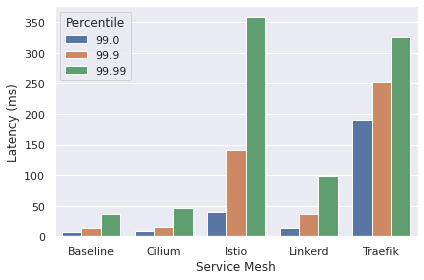

In [4]:
"""
PLOT: Tail End Latencies
"""

# Plotting
file_name = f"{file_prefix}-tail-latencies.pdf"

fig, ax = plt.subplots()
ax = sns.barplot(data=data, x="mesh", y="latency", hue="percentile")

# Scaling
# ax.set_xscale()
# ax.set_yscale()

# Limits
# ax.set_xscale()
# ax.set_yscale()

# Labels
ax.set_xlabel("Service Mesh")
ax.set_ylabel("Latency (ms)")

# ax.legend(labels=["p99", "p99.9", "p99.99"], title= "Percentiles")
ax.legend(title= "Percentile")

fig.tight_layout()
fig.savefig(plot_dir / file_name)